<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Probability-Calibration" data-toc-modified-id="Probability-Calibration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Probability Calibration</a></span><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data Preparation</a></span></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Model Training</a></span></li><li><span><a href="#Calibration-Curve" data-toc-modified-id="Calibration-Curve-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Calibration Curve</a></span></li><li><span><a href="#Model-Calibration" data-toc-modified-id="Model-Calibration-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Model Calibration</a></span></li><li><span><a href="#Customizing-Scikit-learn-Calibrated-Classifier" data-toc-modified-id="Customizing-Scikit-learn-Calibrated-Classifier-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Customizing Scikit-learn Calibrated Classifier</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', '..', 'notebook_format'))

from formats import load_style
load_style(css_style='custom2.css', plot_style=False)

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split

# prevent scientific notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn,matplotlib,xgboost,lightgbm

Ethen 2020-08-23 21:31:33 

CPython 3.6.4
IPython 7.15.0

numpy 1.19.0
pandas 1.0.5
sklearn 0.23.1
matplotlib 3.1.0
xgboost 1.0.0
lightgbm 2.3.1


# Probability Calibration

Well calibrated classifiers are classifiers for which the output probability (for sklearn, this is the output of the `predict_proba` method) can be directly interpreted as a confidence level. The definition of a well calibrated (binary) classifier should classify the samples such that among the samples which the model gave a predicted probability value close to 0.8, approximately 80% of them actually belong to the positive class.

Some examples of why checking whether probability are calibrated matters:

When looking up the weather forecast, we usually get a precipitation probability. e.g. If the weather forecast says there's a 80% chance of raining, then how trustworthy is this probability? Or if I take 100 days of data that were claimed to have a 80% chance of raining, how many rainy days were there. If the number of rainy days were around 80, then that means we can trust that particular rain forecast.

Another example is: after training say a binary classifier, the output we get from methods `predict_proba` might just be a ranking score instead of well calibrated probability. A ranking score is essentially evaluating how well does the model score positive examples above negative ones, whereas a calibrated probability is evaluating how closely the scores generated by our model resembles an actual probability. Obtaining a well calibrated probability becomes important when we wish to do something along the lines of:

- Use the probability threshold to inform some action. e.g. We'll reject the loan approval if the default rate is higher than 50%.
- If our ranking formula is not solely based on the original model's score. In some cases, we may wish to use the score/probability along with some additional factors for ranking purpose. e.g. In the [advertising cost per click model](https://turi.com/learn/gallery/notebooks/click_through_rate_prediction_intro.html), we're going to rank the ads by its expected value (the probability of clicking on the ad multiplied by the ad fee for the click).

## Data Preparation

We'll be using the credit card default dataset from UCI, we can download this dataset from [Kaggle](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset) as well.

In [3]:
input_path = 'UCI_Credit_Card.csv'
df = pd.read_csv(input_path)
print(df.shape)
df.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.000,2,2,1,24,2,2,-1,-1,...,0.000,0.000,0.000,0.000,689.000,0.000,0.000,0.000,0.000,1
1,2,120000.000,2,2,2,26,-1,2,0,0,...,3272.000,3455.000,3261.000,0.000,1000.000,1000.000,1000.000,0.000,2000.000,1
2,3,90000.000,2,2,2,34,0,0,0,0,...,14331.000,14948.000,15549.000,1518.000,1500.000,1000.000,1000.000,1000.000,5000.000,0
3,4,50000.000,2,2,1,37,0,0,0,0,...,28314.000,28959.000,29547.000,2000.000,2019.000,1200.000,1100.000,1069.000,1000.000,0
4,5,50000.000,1,2,1,57,-1,0,-1,0,...,20940.000,19146.000,19131.000,2000.000,36681.000,10000.000,9000.000,689.000,679.000,0


In [4]:
id_cols = ['ID']
cat_cols = ['EDUCATION', 'SEX', 'MARRIAGE']
num_cols = [
    'LIMIT_BAL', 'AGE',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]
label_col = 'default.payment.next.month'

input_cols = num_cols + cat_cols

In [5]:
label_distr = np.round(np.bincount(df[label_col]) / df.shape[0], 3)
print('label distribution: ', label_distr)

label distribution:  [0.779 0.221]


We'll generate a train/validation/test three way split. The validation set created here is mainly used to calibrate our model. As per good practice, we should not be using the same dataset on both the training & calibrating process.

In [6]:
test_size = 0.1
val_size = 0.3
random_state = 1234

df_train, df_test = train_test_split(
    df,
    test_size=test_size,
    random_state=random_state,
    stratify=df[label_col])

df_train, df_val = train_test_split(
    df_train,
    test_size=val_size,
    random_state=random_state,
    stratify=df_train[label_col])

print('train shape: ', df_train.shape)
print('validation shape: ', df_val.shape)
print('test shape: ', df_test.shape)

df_train.head()

train shape:  (18900, 25)
validation shape:  (8100, 25)
test shape:  (3000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
9256,9257,20000.000,2,3,1,23,1,2,2,-2,...,0.000,0.000,0.000,480.000,0.000,0.000,0.000,0.000,0.000,1
23220,23221,150000.000,2,3,2,35,-1,2,-1,2,...,1143.000,163.000,2036.000,0.000,2264.000,0.000,163.000,2036.000,0.000,0
11074,11075,260000.000,2,2,1,43,2,2,2,2,...,2500.000,2500.000,2500.000,0.000,0.000,0.000,0.000,0.000,0.000,1
1583,1584,50000.000,2,1,2,70,2,2,0,0,...,17793.000,18224.000,18612.000,0.000,2200.000,700.000,700.000,674.000,608.000,0
8623,8624,390000.000,2,2,1,45,1,-2,-2,-2,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3971.000,1


## Model Training

We'll train a binary classifier to predict default payment, and evaluate the model using some common evaluation metrics. In our example, we'll only focus on the widely used boosted tree including xgboost and lightgbm.

In [7]:
# parameters chosen in an adhoc manner
xgb_params = {
    'n_estimators': 300,
    'colsample_bytree': 0.7,
    'subsample': 0.8,
    'max_depth': 3,
    'learning_rate': 0.1
}
xgb = XGBClassifier(**xgb_params)
xgb.fit(df_train[input_cols], df_train[label_col])

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method=None, validate_parameters=False, verbosity=None)

In [8]:
lgb_params = {
    'boosting_type': 'gbdt',
    'n_estimators': 300,
    'learning_rate': 0.1,
    'min_child_samples': 51,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'num_leaves': 76
}

# configuring the model
lgb = LGBMClassifier(**lgb_params)
lgb.fit(df_train[input_cols], df_train[label_col])

LGBMClassifier(colsample_bytree=0.7, max_depth=3, min_child_samples=51,
               n_estimators=300, num_leaves=76, subsample=0.8)

In [9]:
def compute_score(model, X, y, verbose=True, round_digits=3):
    """
    The following blog contains introduction to various evaluation metrics
    for binary classifier.
    
    https://neptune.ml/blog/evaluation-metrics-binary-classification
    """
    y_score = model.predict_proba(X)[:, 1]

    auc = round(metrics.roc_auc_score(y, y_score), round_digits)
    log_loss = round(metrics.log_loss(y, y_score), round_digits)
    brier = round(metrics.brier_score_loss(y, y_score), round_digits)

    precision, recall, threshold = metrics.precision_recall_curve(y, y_score)
    f1 = 2 * (precision * recall) / (precision + recall)

    mask = ~np.isnan(f1)
    f1 = f1[mask]
    precision = precision[mask]
    recall = recall[mask]

    best_index = np.argmax(f1)
    precision = round(precision[best_index], round_digits)
    recall = round(recall[best_index], round_digits)
    f1 = round(f1[best_index], round_digits)

    if verbose:
        print('auc: ', auc)
        print('precision: ', precision)
        print('recall: ', recall)
        print('f1: ', f1)
        print('brier: ', brier)
        print('log_loss: ', log_loss)

    return {
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'log_loss': log_loss,
        'brier': brier
    }

In [10]:
# evaluate the metrics for training and test set
estimators_names = [
    (xgb, 'xgb'),
    (lgb, 'lgb')
]
df_groups = (df_train, df_test), ('train', 'test')

estimator_metrics = []
for estimator, name in estimators_names:
    for df_group, df_name in zip(*df_groups):
        metric_dict = compute_score(estimator, df_group[input_cols], df_group[label_col], verbose=False)
        metric_dict['name'] = name + '_' + df_name
        estimator_metrics.append(metric_dict)
    
df_metrics = pd.DataFrame(estimator_metrics)
df_metrics

,auc,precision,recall,f1,log_loss,brier,name
0,0.843,0.546,0.657,0.596,0.387,0.121,xgb_train
1,0.771,0.523,0.556,0.539,0.438,0.138,xgb_test
2,0.832,0.516,0.671,0.583,0.395,0.124,lgb_train
3,0.772,0.518,0.554,0.535,0.437,0.137,lgb_test


## Calibration Curve

[`calibration_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html) or also known as reliability diagram is a common way to visualize whether the score output from the model is well calibrated or not.

To construct the graph, we discretize the predicted probability into $n$ bins ($n$ is configurable, usually 10). Instances with predicted value between 0 and 0.1 are placed in the first bin, between 0.1 and 0.2 are placed in the second bin and so on. Then for each bin, the mean predicted probability is plotted against the fraction of positive cases for that bin. If the model is well-calibrated, then the points will fall near the diagonal line.

In [11]:
def plot_calibration_curve(estimators_names, X, y):

    fig, (ax1, ax2) = plt.subplots(2)

    # estimator_metrics stores list of dict, e.g.
    #     [{'auc': 0.776,
    #       'precision': 0.566,
    #       'recall': 0.523,
    #       'f1': 0.543,
    #       'name': 'xgb'}]
    estimator_metrics = []
    for estimator, name in estimators_names:
        proba = estimator.predict_proba(X)[:, 1]
        prob_true, prob_pred = calibration_curve(y, proba, n_bins=10)

        metric_dict = compute_score(estimator, X, y, verbose=False)
        metric_dict['name'] = name
        estimator_metrics.append(metric_dict)

        ax1.plot(prob_pred, prob_true, 's-', label=name)
        ax2.hist(proba, range=(0, 1), bins=10, label=name, histtype='step', lw=2)

    ax1.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')

    ax1.set_xlabel('Fraction of positives (Predicted)')
    ax1.set_ylabel('Fraction of positives (Actual)')
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc='lower right')
    ax1.set_title('Calibration Plots (Reliability Curve)')

    ax2.set_xlabel('Predicted scores')
    ax2.set_ylabel('Count')
    ax2.set_title('Histogram of Predicted Scores')
    ax2.legend(loc='upper center', ncol=2)

    plt.tight_layout()
    df_metrics = pd.DataFrame(estimator_metrics)
    return df_metrics

,auc,precision,recall,f1,log_loss,brier,name
0,0.843,0.546,0.657,0.596,0.387,0.121,xgb
1,0.832,0.516,0.671,0.583,0.395,0.124,lgb


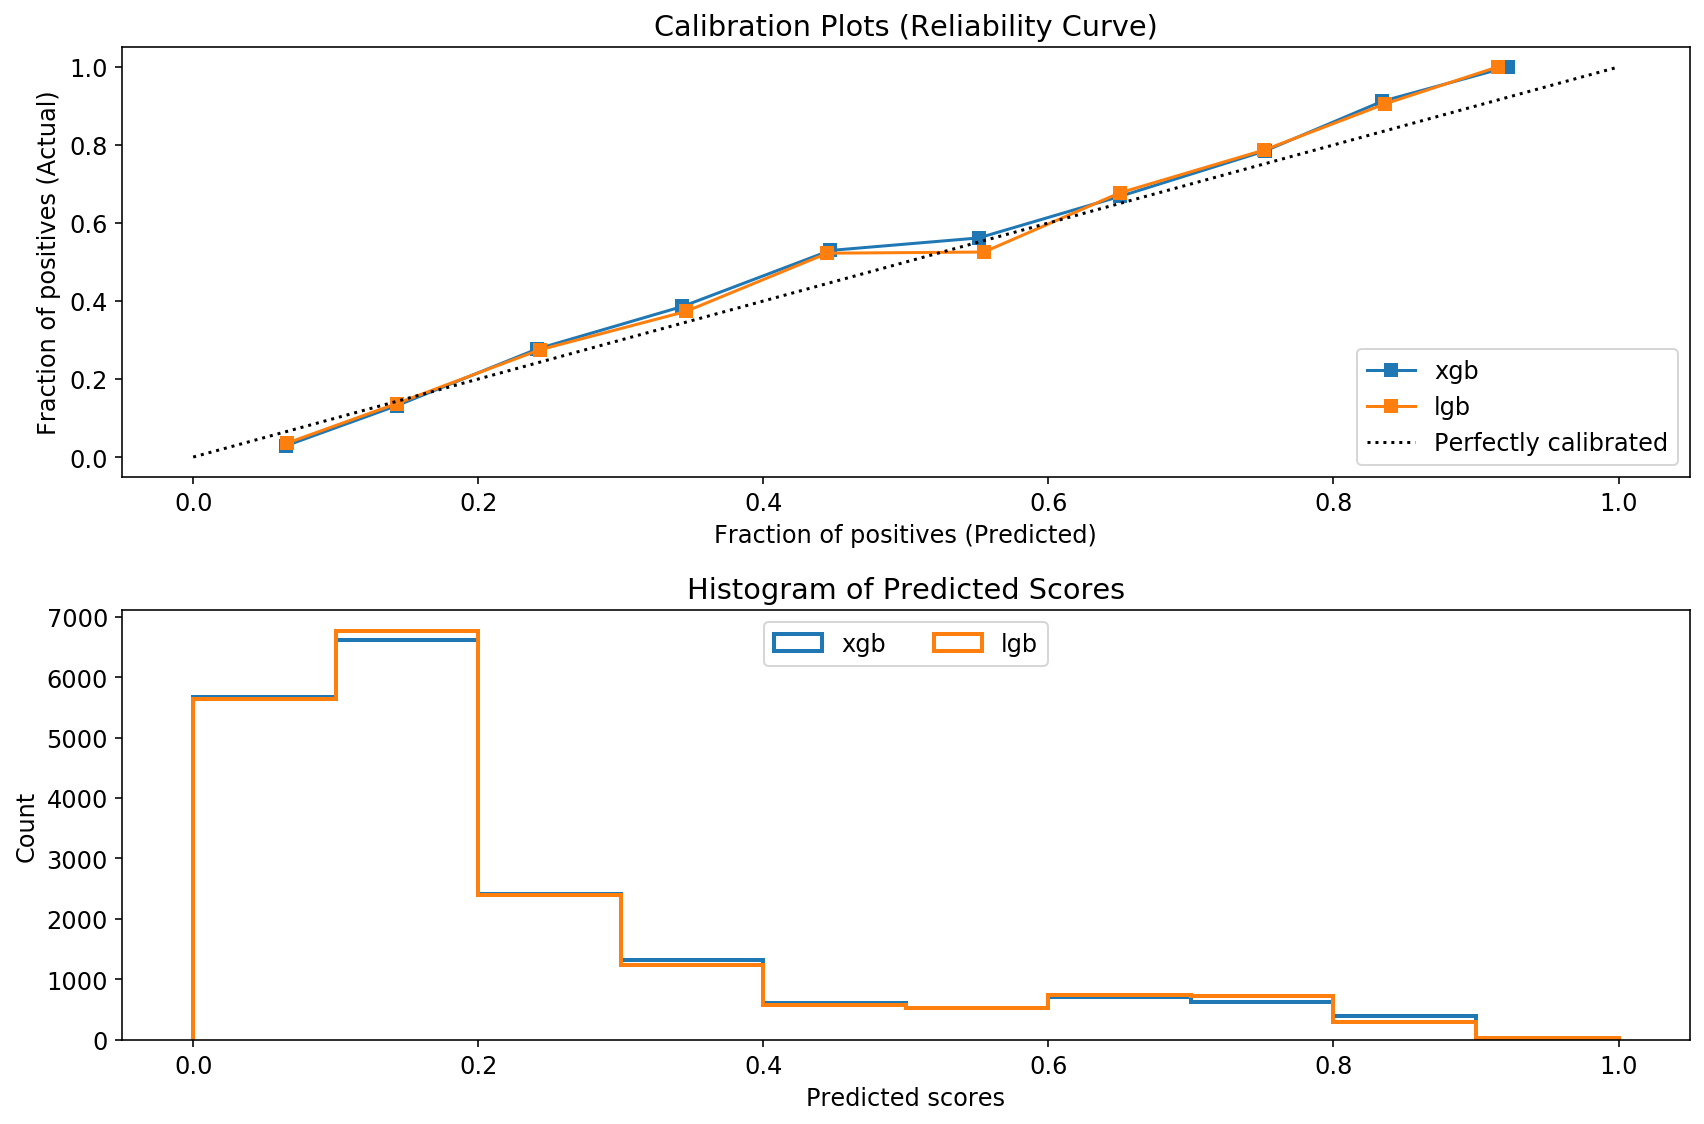

In [12]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['font.size'] = 12

# calibration curve for the training set
estimators_names = [
    (xgb, 'xgb'),
    (lgb, 'lgb')
]
df_metrics = plot_calibration_curve(estimators_names, df_train[input_cols], df_train[label_col])
df_metrics

If we look at the calibration plot, we can see there are some points that fall above and below the diagonal line.

- Below the diagonal: The model has over-forecast; the probabilities are too large.
- Above the diagonal: The model has under-forecast; the probabilities are too small.

But from the looks of it, it seems like the predicted score is pretty well calibrated as the dots fall closely to the diagonal line.

## Model Calibration

Calibration of prediction scores is a rescaling operation that is applied after the predictions have been made by a predictive model. The high-level procedure to train the calibration model is to make sure the data that is used to fit the original estimator and the one that is used for calibration does not overlap. e.g.

- We can split the data into training / validation set, After our base model is trained on the training
set, the predictions on the validation set are used to fit the calibration model.
- Or do it in a cross validation way, where the data is split into $C$ folds. For each fold, one part is held
aside for use as an validation set while the training is performed using the other $C-1$ fold. After repeating the process for all $C$ folds, we can compute final probability by doing an arithmetic mean of the calibrated classifier's predictions.

As for the calibration model, two popular ones are **Platt Scaling** and **Isotonic Regression**.

- **Platt Scaling:** At a high level, Platt Scaling amounts to training a logistic regression on of the original classifier's output with respect to the true class labels.
- **Isotonic Regression:** With this approach, the idea is to fit a piecewise constant non-decreasing function. At a high level, the idea is to merge similar scores into bins such that each bin becomes monotonically increasing. e.g. The first bin may have the range [0, 0.2] and probability 0.15, meaning that any instance with a score between 0 and 0.2 should be assigned a probability estimate of 0.15.

To evaluate whether we successfully calibrated our model, we can/should check various evaluation metrics for our calibrated model. Our ranking metrics such as AUC should remain somewhat the same, whereas our probability-related metrics such as log-loss should improve.

In general, platt scaling is preferable if the calibration curve has a sigmoid shape and when there is few calibration data, while isotonic regression, being a non-parametric method, is preferable for non-sigmoid calibration curves and in situations where many additional data can be used for calibration. But again, it doesn't hurt to try both approaches.

The following code chunk shows how to perform probability calibration for scikit-learn like estimators. Other machine learning packages such as [h2o](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/calibrate_model.html) also provides this capability.

## Customizing Scikit-learn Calibrated Classifier

Here, we'll be making some modifications to scikit-learn's [CalibratedClassifierCV](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html) class to make it suitable for our use-case. The reason being:

If we are to use the `prefit` argument, where our base estimator has been fitted already and all data is used for calibration. Then we would run into a feature name mismatch issue. This is because inside the class, the `check_X_y` method converts our input dataframe into a numpy array, causing the feature name from the dataframe to be un-aligned with the numpy array.

```python
# https://github.com/dmlc/xgboost/issues/2334#issuecomment-406282203
# Calibrated with sigmoid calibration
from sklearn.calibration import CalibratedClassifierCV

xgb_sigmoid = CalibratedClassifierCV(xgb, method='sigmoid', cv='prefit')
xgb_sigmoid.fit(df_val[input_cols], df_val[label_col])
# doing this will throw feature name mismatch error at the time of writing
```

The second customization is the `_CalibratedClassifier` that is used within `CalibratedClassifierCV`. This is the class that actually fits the calibration model. An issue occurs when we tried to use the `isotonic` option for the calibration model, a dtype mismatch error occurs. This is due to the fact that the predicted score from our boosted tree model is of type np.float32 (float), whereas scikit-learn's isotonic regression expects np.float64 (double). Hence the fix is to coerce the predicted score to a double.

```python
from sklearn.calibration import _CalibratedClassifier

calibrated_classifier = _CalibratedClassifier(xgb, method='isotonic')
calibrated_classifier.fit(df_val[input_cols], df_val[label_col])
# ValueError: Buffer dtype mismatch, expected 'float' but got 'double'
```

In [13]:
from sklearn.utils.validation import check_is_fitted
from sklearn.calibration import (CalibratedClassifierCV,
                                 _CalibratedClassifier,
                                 _SigmoidCalibration)
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, label_binarize
from sklearn.isotonic import IsotonicRegression


class CalibratedPrefitClassifier(CalibratedClassifierCV):

    def __init__(self, base_estimator, method):
        super().__init__(base_estimator, method, cv='prefit')

    def fit(self, X, y, sample_weight=None):
        """
        Fit the calibrated model

        Parameters
        ----------
        X : pd.DataFrame, shape (n_samples, n_features)
            Training data.

        y : array-like, shape (n_samples,)
            Target values.

        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights. If None, then samples are equally weighted.

        Returns
        -------
        self : object
            Returns an instance of self.
        """
        # scikit-learn has a check_X_y here that will convert our dataframe
        # to a numpy array, remove that part to prevent the conversion

        le = LabelBinarizer().fit(y)
        self.classes_ = le.classes_

        # the main difference from scikit-learn is that our cv parameter will
        # always be 'prefit', hence we don't need to handle the cross validation case,
        # we still honor that original attribute list type, even though it isn't necessary
        self.calibrated_classifiers_ = []
        calibrated_classifier = CalibratedClassifier(self.base_estimator, method=self.method)
        if sample_weight is not None:
            calibrated_classifier.fit(X, y, sample_weight)
        else:
            calibrated_classifier.fit(X, y)

        self.calibrated_classifiers_.append(calibrated_classifier)
        return self

    def predict_proba(self, X):
        """
        Posterior probabilities of classification

        This function returns posterior probabilities of classification
        according to each class on an array of test vectors X.

        Parameters
        ----------
        X : pd.DataFrame, shape (n_samples, n_features)
            The samples.

        Returns
        -------
        proba : array, shape (n_samples, n_classes)
            The predicted probas.
        """
        # the check_is_fitted method might change to not needing to pass
        # the attribute that we're checking for in the future
        check_is_fitted(self, ['classes_', 'calibrated_classifiers_'])

        # Compute the arithmetic mean of the predictions of the calibrated
        # classifiers
        mean_proba = np.zeros((X.shape[0], len(self.classes_)))
        for calibrated_classifier in self.calibrated_classifiers_:
            proba = calibrated_classifier.predict_proba(X)
            mean_proba += proba

        mean_proba /= len(self.calibrated_classifiers_)
        return mean_proba


class CalibratedClassifier(_CalibratedClassifier):

    def fit(self, X, y, sample_weight=None):
        """
        Calibrate the fitted model

        Parameters
        ----------
        X : pd.DataFrame, shape (n_samples, n_features)
            Training data.

        y : array-like, shape (n_samples,)
            Target values.

        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights. If None, then samples are equally weighted.

        Returns
        -------
        self : object
            Returns an instance of self.
        """
        self.label_encoder_ = LabelEncoder()
        if self.classes is None:
            self.label_encoder_.fit(y)
        else:
            self.label_encoder_.fit(self.classes)

        self.classes_ = self.label_encoder_.classes_
        Y = label_binarize(y, self.classes_)

        # df is the predicted score/probability of the base_estimator
        df, idx_pos_class = self._preproc(X)

        self.calibrators_ = []
        for k, this_df in zip(idx_pos_class, df.T):
            if self.method == 'isotonic':
                # coerce the predicted score to a double to prevent type error
                this_df = this_df.astype(np.float64)
                calibrator = IsotonicRegression(out_of_bounds='clip')
            elif self.method == 'sigmoid':
                calibrator = _SigmoidCalibration()
            else:
                raise ValueError('method should be "sigmoid" or '
                                 '"isotonic". Got %s.' % self.method)
            calibrator.fit(this_df, Y[:, k], sample_weight)
            self.calibrators_.append(calibrator)

        return self

We calibrate the probability using both Platt Scaling and Isotonic Regression on the validation set and evaluate their calibration curve and evaluation metrics on the test set.

In [14]:
xgb_sigmoid = CalibratedPrefitClassifier(xgb, method='sigmoid')
xgb_sigmoid.fit(df_val[input_cols], df_val[label_col])

CalibratedPrefitClassifier(base_estimator=XGBClassifier(base_score=0.5,
                                                        booster=None,
                                                        colsample_bylevel=1,
                                                        colsample_bynode=1,
                                                        colsample_bytree=0.7,
                                                        gamma=0, gpu_id=-1,
                                                        importance_type='gain',
                                                        interaction_constraints=None,
                                                        learning_rate=0.1,
                                                        max_delta_step=0,
                                                        max_depth=3,
                                                        min_child_weight=1,
                                                        missing=nan,
                      

In [15]:
xgb_isotonic = CalibratedPrefitClassifier(xgb, method='isotonic')
xgb_isotonic.fit(df_val[input_cols], df_val[label_col])

CalibratedPrefitClassifier(base_estimator=XGBClassifier(base_score=0.5,
                                                        booster=None,
                                                        colsample_bylevel=1,
                                                        colsample_bynode=1,
                                                        colsample_bytree=0.7,
                                                        gamma=0, gpu_id=-1,
                                                        importance_type='gain',
                                                        interaction_constraints=None,
                                                        learning_rate=0.1,
                                                        max_delta_step=0,
                                                        max_depth=3,
                                                        min_child_weight=1,
                                                        missing=nan,
                      

,auc,precision,recall,f1,log_loss,brier,name
0,0.771,0.523,0.556,0.539,0.438,0.138,xgb
1,0.771,0.523,0.556,0.539,0.442,0.139,xgb_sigmoid
2,0.770,0.523,0.556,0.539,0.448,0.138,xgb_isotonic


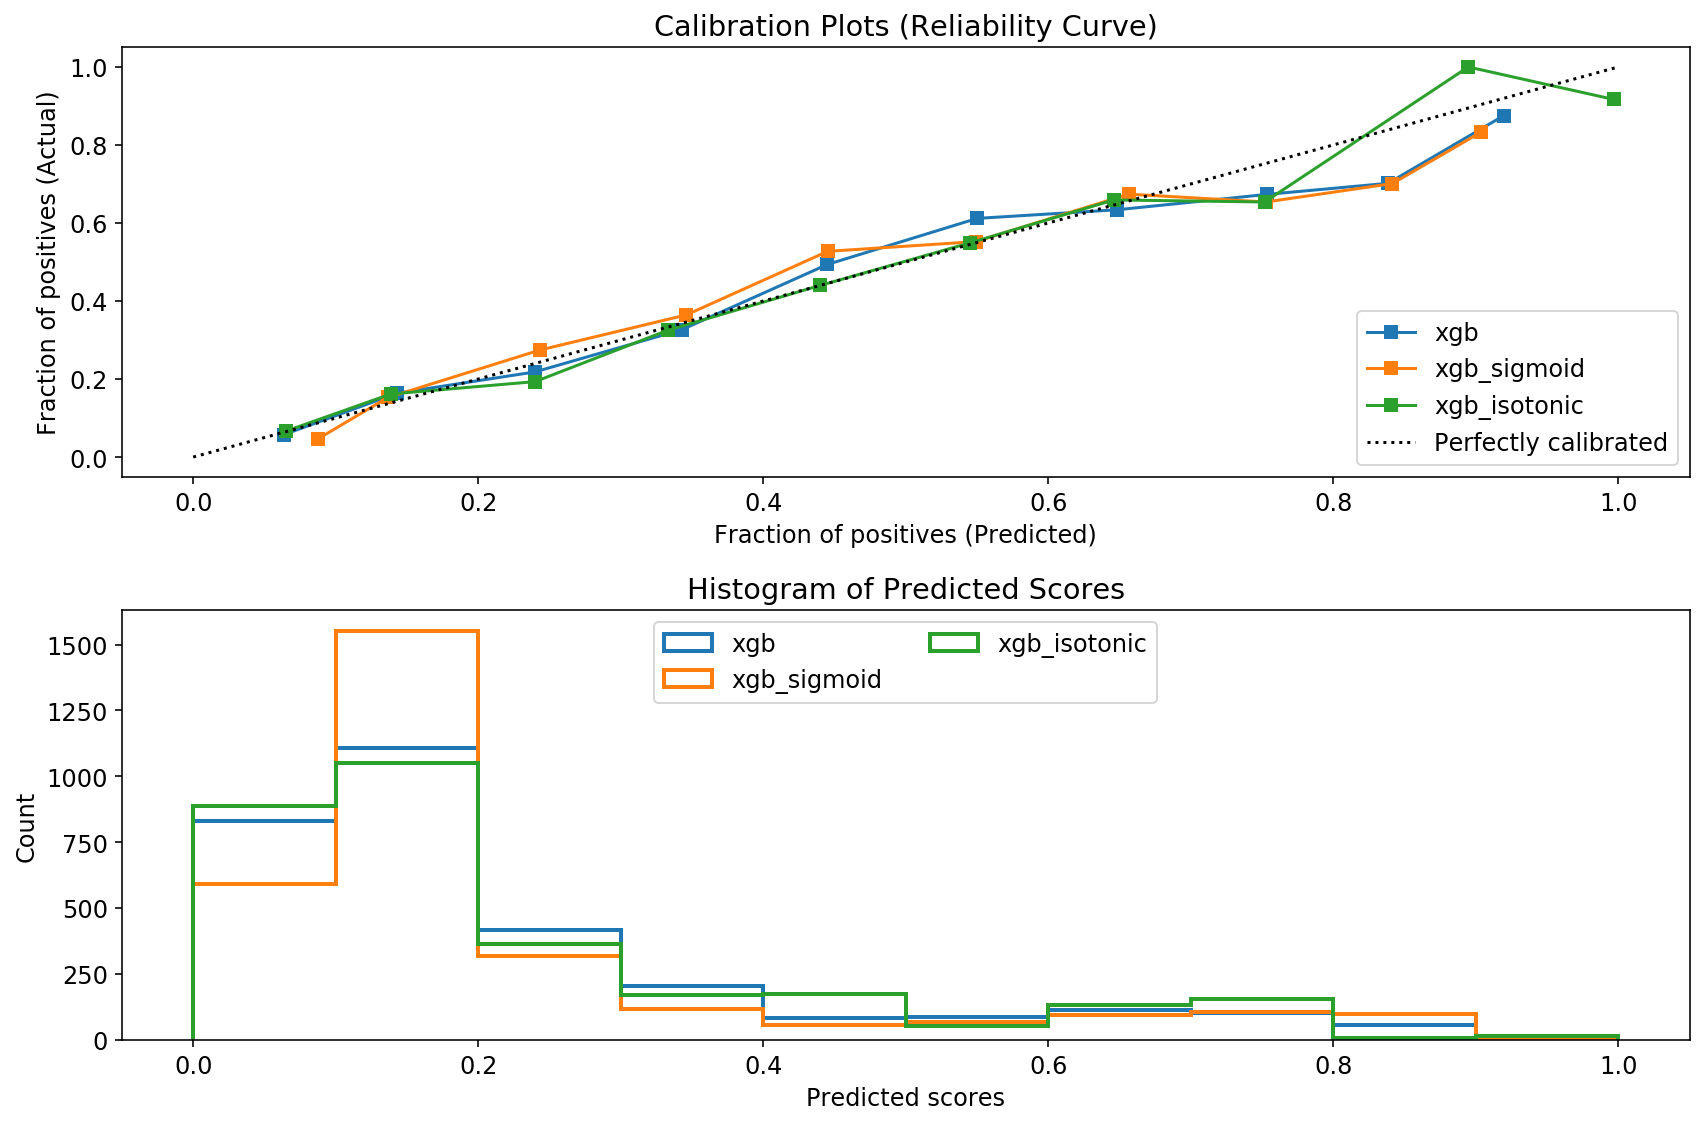

In [16]:
estimators_names = [
    (xgb, 'xgb'),
    (xgb_sigmoid, 'xgb_sigmoid'),
    (xgb_isotonic, 'xgb_isotonic')
]
df_metrics = plot_calibration_curve(estimators_names, df_test[input_cols], df_test[label_col])
df_metrics

From the looks of things, it seems like the original boosted tree model doesn't really gain much from performing calibration. The log-loss of the original model versus the log-loss of the calibrated model (sigmoid and isotonic are two different ways of performing calibration) remained somewhat similar. And the fact that the plotted calibration curve also looks similar, confirms the hypothesis.

The [sklearn documentation](https://scikit-learn.org/stable/modules/calibration.html) also contains a page that looks at how well various classifiers' predicted score are calibrated.

# Reference

- [Blog: Probability calibration](https://jmetzen.github.io/2015-04-14/calibration.html)
- [Blog: A Guide to Calibration Plots in Python](https://changhsinlee.com/python-calibration-plot/)
- [Blog: How and When to Use a Calibrated Classification Model with scikit-learn](https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/)
- [Sklearn Documentation: Probability calibration](https://scikit-learn.org/stable/modules/calibration.html)
- [Sklearn Documentation: Probability calibration curves](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html)
- [Paper: A. Niculescu-Mizil, R. Caruana (2012) - Obtaining Calibrated Probabilities from Boosting](https://arxiv.org/abs/1207.1403)